# **Arabic Diacritization Using Deep Neural Networks**

In this project, I aim to take a deep learning approach to the problem of Arabic
Diacritization. my first milestone is to reproduce the work by  the results by Fadel et al. [1], using an RNN model


Two measures have been developed to measure the accuracy of a diacritization
system. The first is the Diacritic Error Rate (DER) which is the percentage of
misclassified Arabic characters whether the character has 0, 1, or 2 diacritics. The other
is Word Error Rate (WER) which is the percentage of words which have at least one misclassified Arabic character.  WER of 8% 

### **I. Import required libraries and supporting files**

I import required numpy, matplotlib, tensorflow, and keras librarsies. We additionally import pickle to unpickle supporting files provided by the athors. 

I downgrade the used tensorflow , numpy version to version 1 ensure compatibility with all used model dependencies. 

In [1]:
# !pip install tensorflow

In [2]:
#!pip install numpy==1.19.5

split our train dataset  to train  and validation

In [3]:
#train_split , val_split =  train_test_split(train_split,test_size = 0.2)

In [4]:
import time
import random
import numpy as np
import pickle as pkl
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, Bidirectional, TimeDistributed , Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

I mount google drive to import all required supporting files. 

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

Additionally, I load the following required dependancies: 
* ARABIC_LETTERS_LIST.pickle - Contains a list of Arabic letters
* DIACRITICS_LIST.pickle - Contains a list of all diacritics
* RNN_CLASSES_MAPPING.pickle - Contains a dictionary, mapping each diactritics class to its unique integer 
* RNN_REV_CLASSES_MAPPING.pickle - Contains a dictionary, mapping each integer to its unique diactritics class 
* RNN_SMALL_CHARACTERS_MAPPING.pickle - Contains a dictionary, mapping each character to its unique integer (Without using using the extra training dataset)
* RNN_BIG_CHARACTERS_MAPPING.pickle - Contains a dictionary, mapping each character to its unique integer (Using using the extra training dataset)

In [6]:
WITH_EXTRA_TRAIN = False # initialliy, extra training data will not be used
DATASET_PATH = 'dataset'
CONSTANTS_PATH = 'linguistic_resources'

with open(CONSTANTS_PATH + '/arabic_letters.pickle', 'rb') as file:
    ARABIC_LETTERS_LIST = pkl.load(file)
with open(CONSTANTS_PATH + '/diacritics.pickle', 'rb') as file:
    DIACRITICS_LIST = pkl.load(file)
     
with open(CONSTANTS_PATH + '/characters2id.pickle', 'rb') as file:
    CHARACTERS_MAPPING = pkl.load(file)
    
with open(CONSTANTS_PATH + '/diacritic2id.pickle', 'rb') as file:
    CLASSES_MAPPING = pkl.load(file)
with open(CONSTANTS_PATH + '/id2diacritic.pickle', 'rb') as file:
    REV_CLASSES_MAPPING = pkl.load(file)

In [7]:
print('DIACRITICS_LIST',REV_CLASSES_MAPPING)

DIACRITICS_LIST {0: 'َ', 1: 'ً', 2: 'ُ', 3: 'ٌ', 4: 'ِ', 5: 'ٍ', 6: 'ْ', 7: 'ّ', 8: 'َّ', 9: 'ًّ', 10: 'ُّ', 11: 'ٌّ', 12: 'ِّ', 13: 'ٍّ', 14: ''}


### **II. Load Dataset**

The used dataset was extracted by Fadel et al. from the Holy Koran and the
Tashkeela Corpus. The only freely available Arabic diacritization dataset, Tashkeela
consists of 97 Classical Arabic books.
The dataset is split into: 
*  train.txt - Contains 438661 lines of diacritized Arabic text
which can be used as training dataset
*  test.txt - Contains 5179 lines of diacritized Arabic text which can be used as testing dataset

Additional extra trainining data could also be imported from extra_train.txt which also contains 50,000 lines of diacritized Arabic text

In [8]:
train_raw = None

with open(DATASET_PATH + '/train.txt', 'r', encoding='utf-8') as file:
    train_raw = file.readlines()


val_raw = None
with open(DATASET_PATH + '/val.txt', 'r', encoding='utf-8') as file:
   val_raw = file.readlines()


### **III. Remove diacrtics supporting functions**

remove_diacritics takes in imported text and replaces all diacritics from the loaded DIACRITICS_LIST with empty characters

In [ ]:
def remove_diacritics(data_raw):
  ''' Returns undiacritized text'''
  return data_raw.translate(str.maketrans('', '', ''.join(DIACRITICS_LIST)))

### **VI. Prepare Data**

The imported dataset was compiled by Fadel et al. from the Tashkeela corpus and the Holy Koran. Fadel et al. performed the following cleaning steps to the dataset: 
* Removing URLs using regex 
* Fixing misplaced or duplicate diacritizatics
* Removing English letters  
* Removing the special Arabic character Kashida as it is irrelevant to diacritization
* Seperating numbers by preceding and following whitespaces using regex
* Removing multiple whitespaces using regex


The function split_data seperates raw data into lines at any pranthesis or punctuation. It then splits long lines into ones shorter than 500 characters. All returned data remains diacitized. 

In [ ]:
def  clean_text(text):
    text = re.sub(r"[-()\"#/@;:_<>{}`﴾﴿ے+=~&|.!?,a-zA-Z0-9-]", "", text)
    return text

In [ ]:
def split_data(data_raw):
    ''' Splits data into a list of sentences, clauses, or lines shorter than 500 characters. '''

    # initialize returned list
    data_new = list()
    
    # create new lines at paranthesis or puctuation
    for line in data_raw:
        line = line.replace('.', '.\n')
        line = line.replace(',', ',\n')
        line = line.replace('،', '،\n')
        line = line.replace(':', ':\n')
        line = line.replace(';', ';\n')
        line = line.replace('؛', '؛\n')
        line = line.replace('(', '\n(')
        line = line.replace(')', ')\n')
        line = line.replace('[', '\n[')
        line = line.replace(']', ']\n')
        line = line.replace('{', '\n{')
        line = line.replace('}', '}\n')
        line = line.replace('«', '\n«')
        line = line.replace('»', '»\n')
        
 
        # loop on created new lines
        for sub_line in line.split('\n'):
            # do nothing if line is empty
            if len(remove_diacritics(sub_line).strip()) == 0:
                continue
            # append line to list if line, without diacritics, is shorter than 500 characters
            if len(remove_diacritics(sub_line).strip()) > 0 and len(remove_diacritics(sub_line).strip()) <= 500:
                data_new.append(sub_line.strip())

            # split line if its longer than 500 characters    
            else:
                sub_line = sub_line.split()
                tmp_line = ''
                for word in sub_line:
                    # append line without current word if new word will make it exceed 500 characters and start new line
                    if len(remove_diacritics(tmp_line).strip()) + len(remove_diacritics(word).strip()) + 1 > 500:
                        if len(remove_diacritics(tmp_line).strip()) > 0:
                            data_new.append(tmp_line.strip())
                        tmp_line = word
                    else:
                        # set new line to current word if line is still empty
                        if tmp_line == '':
                            tmp_line = word
                        # add whitespace and word to line if line is not empty but shorter than 500 characters
                        else:
                            tmp_line += ' '
                            tmp_line += word
                if len(remove_diacritics(tmp_line).strip()) > 0:
                    data_new.append(tmp_line.strip())

    return data_new

In [ ]:
CHARACTERS_MAPPING['<SOS>'] =  -1
CLASSES_MAPPING['<SOS>'] = -1
CHARACTERS_MAPPING['<EOS>'] =  -2
CLASSES_MAPPING['<EOS>'] = -2
CHARACTERS_MAPPING['<PAD>'] =  -3
CLASSES_MAPPING['<PAD>'] = -3
CHARACTERS_MAPPING['<UNK>'] =  -4
CLASSES_MAPPING['<UNK>'] = -4


CHARACTERS_MAPPING[' '] = 36

print(CHARACTERS_MAPPING)

The function map data splits dataset lines to an array of characters represented by their corresponding integers and an array of their diacritics represented by one-hot-encoded arrays. 

In [ ]:
def map_data(data_raw):
    ''' Splists data lines into an array of charachers as integers and an array of discritics as one-hot-encodings '''

    # initialize data and diacritics lists
    X = list()
    Y = list()
    
    # loop on data lines
    for line in data_raw: 
        # initialize line data and diacritics lists and add start of sentence character       
        x = [CHARACTERS_MAPPING['<SOS>']]
        y = [CLASSES_MAPPING['<SOS>']]
        
        # loop on all characters in line
        for idx, char in enumerate(line):
            # skip character if it is only a dicritic
            if char in DIACRITICS_LIST:
                continue
            # append character mapping to data list
            if char in CHARACTERS_MAPPING:
                x.append(CHARACTERS_MAPPING[char])
            else:
                x.append(CHARACTERS_MAPPING['<UNK>'])
            
            # if character is not an arabic letter append whitespace to diacritics list
            if char not in ARABIC_LETTERS_LIST:
                y.append(CLASSES_MAPPING[''])
            # if character is an arabic letter append its discritics (following 1 or 2 characters) to diacritics list
            else:
                char_diac = ''
                if idx + 1 < len(line) and line[idx + 1] in DIACRITICS_LIST:
                    char_diac = line[idx + 1]
                    if idx + 2 < len(line) and line[idx + 2] in DIACRITICS_LIST and char_diac + line[idx + 2] in CLASSES_MAPPING:
                        char_diac += line[idx + 2]
                    elif idx + 2 < len(line) and line[idx + 2] in DIACRITICS_LIST and line[idx + 2] + char_diac in CLASSES_MAPPING:
                        char_diac = line[idx + 2] + char_diac
                y.append(CLASSES_MAPPING[char_diac])
        
        # assert characters list length equals diacritics list length 
        assert(len(x) == len(y))
        
        # append end of sentence character
        x.append(CHARACTERS_MAPPING['<EOS>'])
        y.append(CLASSES_MAPPING['<EOS>'])
        
        # convert diacritics integers to one_hot_encodings
        y = to_categorical(y, len(CLASSES_MAPPING))
      
        # append line's data and diacritics lists to total data and diacritics lists
        X.append(x)
        Y.append(y)
    
    # convert lists to numpy arrays
    X = np.asarray(X)
    Y = np.asarray(Y)
    
    return X, Y

Split training and validation data

In [ ]:
# perform split_data on training and validation data
train_split = split_data(train_raw)
val_split = split_data(val_raw)

In [ ]:
for i in range(len(train_split)):
    train_split[i] =  clean_text(train_split[i])


In [ ]:
for i in range(len(val_split)):
    val_split[i] =  clean_text(val_split[i])


### **V. Model** 

The used model, designed by Fadel et al., contains the following layers: 

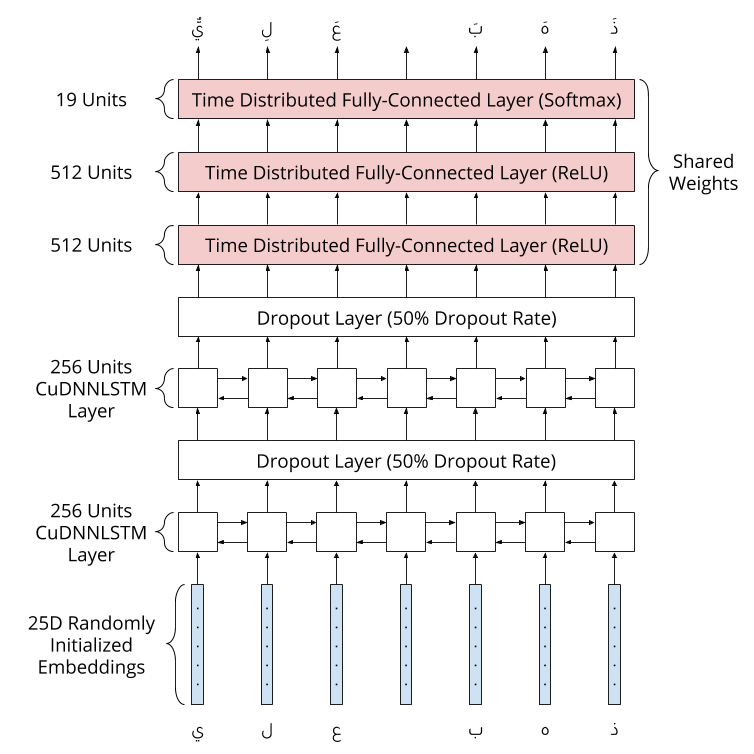

The used CuDDLSTM layers are bidirectional LTSM layers, where CuDDLTSM is a fast LSTM implementation backed by CuDNN and runable on GPU with the tensorflow backend. 

A bidirectional LTSM runs inputs in two ways, one from past to future and one from future to past, allowing the model to preserve information from both past and future.

In [ ]:
def create_model():
    ''' Creates diacritization model '''


    SelectedLSTM = LSTM
    
    inputs = Input(shape=(None,))
    
    embeddings = Embedding(input_dim=len(CHARACTERS_MAPPING),
                           output_dim=25,
                           embeddings_initializer=glorot_normal(seed=961))(inputs)
    
    blstm1 = Bidirectional(SelectedLSTM(units=256,
                                     return_sequences=True,
                                     kernel_initializer=glorot_normal(seed=961)))(embeddings)
    dropout1 = Dropout(0.5)(blstm1)
    blstm2 = Bidirectional(SelectedLSTM(units=256,
                                     return_sequences=True,
                                     kernel_initializer=glorot_normal(seed=961)))(dropout1)
    dropout2 = Dropout(0.5)(blstm2)
    
    dense1 = TimeDistributed(Dense(units=512,
                                   activation='relu',
                                   kernel_initializer=glorot_normal(seed=961)))(dropout2)
    dense2 = TimeDistributed(Dense(units=512,
                                   activation='relu',
                                   kernel_initializer=glorot_normal(seed=961)))(dense1)
    
    output = TimeDistributed(Dense(units=len(CLASSES_MAPPING),
                                   activation='softmax',
                                   kernel_initializer=glorot_normal(seed=961)))(dense2)
    
    model = Model(inputs, output)
    
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=Adam())
    
    return model

In [18]:
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 25)          1025      
                                                                 
 bidirectional (Bidirectiona  (None, None, 512)        577536    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 512)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 512)        1574912   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, None, 512)         0     

### **VI. Training**

Loading the training and validation data to the model uses a costumized data generator. 

In [19]:
class DataGenerator(Sequence):
    ''' Costumized data generator to input line batches into the model '''
    def __init__(self, lines, batch_size):
        self.lines = lines
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.lines) / float(self.batch_size)))

    def __getitem__(self, idx):
        lines = self.lines[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch, Y_batch = map_data(lines)
        
        X_max_seq_len = np.max([len(x) for x in X_batch])
        Y_max_seq_len = np.max([len(y) for y in Y_batch])
        
        assert(X_max_seq_len == Y_max_seq_len)
        
        X = list()
        for x in X_batch:
            x = list(x)
            x.extend([CHARACTERS_MAPPING['<PAD>']] * (X_max_seq_len - len(x)))
            X.append(np.asarray(x))
        
        Y_tmp = list()
        for y in Y_batch:
            y_new = list(y)
            y_new.extend(to_categorical([CLASSES_MAPPING['<PAD>']] * (Y_max_seq_len - len(y)), len(CLASSES_MAPPING)))
            Y_tmp.append(np.asarray(y_new))
        Y_batch = Y_tmp
        
        Y_batch = np.array(Y_batch)
        
        return (np.array(X), Y_batch)

In [20]:
def fit_model(model, epochs, batch_size, train_split,val_split):
    ''' Fits model '''

    
    # create training and validation generators
    training_generator = DataGenerator(train_split, batch_size)
    val_generator = DataGenerator(val_split, batch_size)
    

    # fit model
    history = model.fit(x=training_generator,
              validation_data=val_generator,
              epochs=epochs
              )

    # return history
    return history

In [21]:
# train at last!
start_time = time.time()
hist_1 = fit_model(model, 2, 256, train_split, val_split)
end_time = time.time()
print('--- %s seconds ---' % round(end_time - start_time, 2))

C:\Users\Khaled Hesham\AppData\Local\Temp\ipykernel_28464\3517709691.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.asarray(X)
C:\Users\Khaled Hesham\AppData\Local\Temp\ipykernel_28464\3517709691.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Y = np.asarray(Y)


Epoch 1/2


InvalidArgumentError: Graph execution error:

Detected at node 'model/embedding/embedding_lookup' defined at (most recent call last):
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Khaled Hesham\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Khaled Hesham\AppData\Local\Temp\ipykernel_28464\3139606717.py", line 3, in <module>
      hist_1 = fit_model(model, 2, 256, train_split, val_split)
    File "C:\Users\Khaled Hesham\AppData\Local\Temp\ipykernel_28464\4030253596.py", line 11, in fit_model
      history = model.fit(x=training_generator,
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\core\embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'model/embedding/embedding_lookup'
indices[180,0] = -1 is not in [0, 41)
	 [[{{node model/embedding/embedding_lookup}}]] [Op:__inference_train_function_12075]

In [ ]:
# plot loss history
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
def predict(line, model):
    ''' predict test line '''
    X, _ = map_data([line])
    predictions = model.predict(X).squeeze()
    # get most probable diacritizations for each character
    predictions = predictions[1:]
    
    # initialize empty output line 
    output = ''
    # loop on input characters and predicted diacritizations
    for char, prediction in zip(remove_diacritics(line), predictions):
        # append character
        output += char
        # if character is not an arabic letter continue
        if char not in ARABIC_LETTERS_LIST:
            continue
        
        if '<' in REV_CLASSES_MAPPING[np.argmax(prediction)]:
            continue

        # if character in arabic letters append predicted diacritization
        output += REV_CLASSES_MAPPING[np.argmax(prediction)]

    return output

In [ ]:
# test sample
print(predict('ذهب الولد الي المدرسة', model))

In [ ]:
print(predict("العصفور فوق الشجرة الكبيرة", model))

In [ ]:
model.save("output.h5")